# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from dataclasses import dataclass, field
from typing import Callable, Union
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')


# Data imputation
from sklearn.preprocessing import QuantileTransformer

# Feature Selection
from sklearn.feature_selection import mutual_info_regression

from sklearn.tree import DecisionTreeRegressor

# import Label encoding
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# Change some pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.width', 1000)
pd.set_option("precision", 10)

# Data acquisition

In [3]:
# Read data
df_train_not_edit = pd.read_csv("data/train.csv")
df_test_not_edit = pd.read_csv("data/test.csv")

df_train = df_train_not_edit.copy().drop(columns=['Id'])
df_test =df_test_not_edit.copy()


In [4]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Feature Modification

### Adding features

In [5]:
# df_train['DateSold'] = df_train[['YrSold', 'MoSold']].astype(str).agg('-'.join, axis=1)
# df_train['HouseAge'] = df_train['YrSold'] - df_train['YearBuilt']

### Changing data type
- After investigating the data, Some feature have numeric values but they are **categorical features**
- **OverallQual** & **OverallCond** will be edited to corresponding string values.
- 'MSSubClass', 
    'BsmtFullBath', 
    'BsmtHalfBath', 
    'FullBath', 
    'HalfBath', 
    'BedroomAbvGr', 
    'KitchenAbvGr', 
    'TotRmsAbvGrd', 
    'Fireplaces',
    'GarageCars',
    '3SsnPorch',
    'MiscVal',
    'MoSold',
    'YrSold',
    'OverallQual', 
    'OverallCond'

In [6]:
# Change numeric to string values in OverallQual and OverallCond features
num2str_values = {
        10:	"Very Excellent",
        9:	"Excellent",
        8:	"Very Good",
        7:	"Good",
        6:	"Above Average",
        5:	"Average",
        4:	"Below Average",
        3:	"Fair",
        2:	"Poor",
        1:	"Very Poor"
        }

df_train['OverallQual'] = df_train['OverallQual'].replace(num2str_values)
df_train['OverallCond'] = df_train['OverallCond'].replace(num2str_values)



# Change some features to categorical 
numbered_cat_feats = [
        'MSSubClass', 
        'BsmtFullBath', 
        'BsmtHalfBath', 
        'FullBath', 
        'HalfBath', 
        'BedroomAbvGr', 
        'KitchenAbvGr', 
        'TotRmsAbvGrd', 
        'Fireplaces',
        'GarageCars',
        '3SsnPorch',
        'MiscVal',
        'MoSold',
        'YrSold',
        'OverallQual', 
        'OverallCond'
    ]

df_train[numbered_cat_feats] = df_train[numbered_cat_feats].astype('object')


# Change Fence name -> FenceQual
df_train = df_train.rename(columns={"Fence": "FenceQual"})


def split_features_by_type(data:pd.DataFrame):
        categorical_feats = data.select_dtypes(include=['object']).columns
        numerical_feats = data.select_dtypes(np.number).columns

        return categorical_feats, numerical_feats
        
categorical_feats, numerical_feats = split_features_by_type(df_train)

## Data validation
- Checking for wrong entries like symbols -,?,#,*,etc.

*Observation*:
- No strange values are found.
- Some features have Nan values.

In [7]:
def get_values_count(data:pd.DataFrame) -> None:
    """
    Calculate the values count for each feature in the DataFrame
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    
    Returns
    -------
    values_count : DataFrame contains values count for each feature
    """
    print("--Value counts in each features--")
    for col in data.columns:
        val_cnts = data[col].value_counts(dropna=False).to_dict()
        if(len(val_cnts)>15):
            continue
        print(f"{col} :{val_cnts}")

def get_unique_values(data:pd.DataFrame):
    """
    Get unique values in each feature
    
    Parameters
    ----------
    data : DataFrame
    
    Returns
    -------
    unique_values : DataFrame contains unique values for each feature
    """

    uniques = pd.DataFrame(data={
        'feature':[],
        'uniques':[]
    })
  
    for col in data.columns:
        unique_values = data[col].unique()
        if(len(unique_values)>100):
            continue

        uniques.loc[len(uniques)] = [col, unique_values]
    
    uniques.index = uniques['feature']
    uniques.drop(columns='feature', inplace=True)
    return uniques
    
def get_strange_values(data:pd.DataFrame):
    """
    Get strange values in each feature
    
    Parameters
    ----------
    data : DataFrame
    
    Returns
    -------
    unique_values : DataFrame contains unique values for each feature
    """

    uniques = pd.DataFrame(data={
        'feature':[],
        'uniques':[]
    })
  
    for col in data.columns:
        unique_values = data[col].unique()
        if(len(unique_values)>100):
            continue

        uniques.loc[len(uniques)] = [col, unique_values]
    
    uniques.index = uniques['feature']
    uniques.drop(columns='feature', inplace=True)
    return uniques
    
get_unique_values(df_train)

,uniques
feature,
MSSubClass,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75, 180, 40]"
MSZoning,"[RL, RM, C (all), FV, RH]"
Street,"[Pave, Grvl]"
Alley,"[nan, Grvl, Pave]"
LotShape,"[Reg, IR1, IR2, IR3]"
LandContour,"[Lvl, Bnk, Low, HLS]"
Utilities,"[AllPub, NoSeWa]"
LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]"
LandSlope,"[Gtl, Mod, Sev]"


# EDA

## Missing values checking
- There is a big percent of missing values in **PoolQC** & **MiscFeature** & **Alley** & **Fence**, as a result, we will remove them later.
- 

,Values,Percentage,Type
PoolQC,1453,99.521,object
MiscFeature,1406,96.301,object
Alley,1369,93.767,object
FenceQual,1179,80.753,object
FireplaceQu,690,47.260,object
LotFrontage,259,17.740,float64
GarageYrBlt,81,5.548,float64
GarageCond,81,5.548,object
GarageType,81,5.548,object
GarageFinish,81,5.548,object


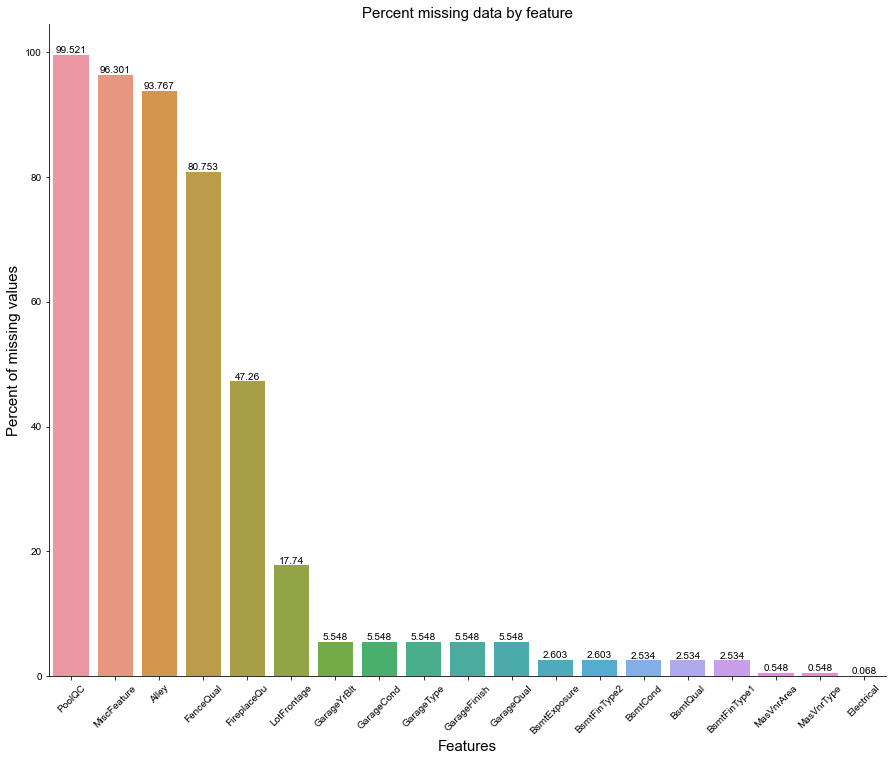

In [8]:
def check_missing_vals(data:pd.DataFrame, with_plot=True):
    """
    Check the presence of Null values in each feature
    
    Parameters
    ----------
    data : DataFrame
    """

    missings = pd.DataFrame()

    missing_vals = data.isnull().sum().sort_values(ascending=False)
    
        
    missing_vals = missing_vals[missing_vals!=0]

    missings.index = missing_vals.index
    missings['Values'] = missing_vals.values
    missings['Percentage'] = round(missings['Values'] / len(data) *100, 3)
    missings['Type'] = data[missings.index].dtypes
    
    if(missing_vals.empty):
        return

    if(with_plot):
        # Plot heatmap of columns that include missing values
        f, ax = plt.subplots(figsize=(15, 12))
        # ax = sns.heatmap(data.isnull()[missings.index], yticklabels=False, cbar=False, cmap='viridis')
        bar_axs = sns.barplot(x=missings.index, y=missings['Percentage'], ax=ax)
        ax.bar_label(bar_axs.containers[-1])
        ax.tick_params('x', rotation=45)
        ax.set_xlabel('Features', fontsize=15)
        ax.set_ylabel('Percent of missing values', fontsize=15)
        ax.set_title('Percent missing data by feature', fontsize=15)
        sns.despine()
        sns.set_style("ticks", {'axes.grid' : True})

    return missings
    
check_missing_vals(df_train)


## Duplicates values checking

In [9]:
def check_duplicates(data:pd.DataFrame) -> list[pd.Index]:
    """Check the presence of duplicates value"""
    dup_indexes = data[data.duplicated()].index
    return dup_indexes

check_duplicates(df_train)

Int64Index([], dtype='int64')

## Statical analysis

### Numerical features

*Summary*:
- We noticing that there are many features have values equal to 0.


In [212]:
df_train.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.0,24.3,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,10516.8,9981.3,1300.0,7553.5,9478.5,11601.5,215245.0
YearBuilt,1460.0,1971.3,30.2,1872.0,1954.0,1973.0,2000.0,2010.0
YearRemodAdd,1460.0,1984.9,20.6,1950.0,1967.0,1994.0,2004.0,2010.0
MasVnrArea,1452.0,103.7,181.1,0.0,0.0,0.0,166.0,1600.0
BsmtFinSF1,1460.0,443.6,456.1,0.0,0.0,383.5,712.2,5644.0
BsmtFinSF2,1460.0,46.5,161.3,0.0,0.0,0.0,0.0,1474.0
BsmtUnfSF,1460.0,567.2,441.9,0.0,223.0,477.5,808.0,2336.0
TotalBsmtSF,1460.0,1057.4,438.7,0.0,795.8,991.5,1298.2,6110.0
1stFlrSF,1460.0,1162.6,386.6,334.0,882.0,1087.0,1391.2,4692.0


### Categorical features

In [213]:
df_train.describe(include=['O']).T

,count,unique,top,freq
MSSubClass,1460,15,20,536
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225


## Univariate analysis

### Numerical variables

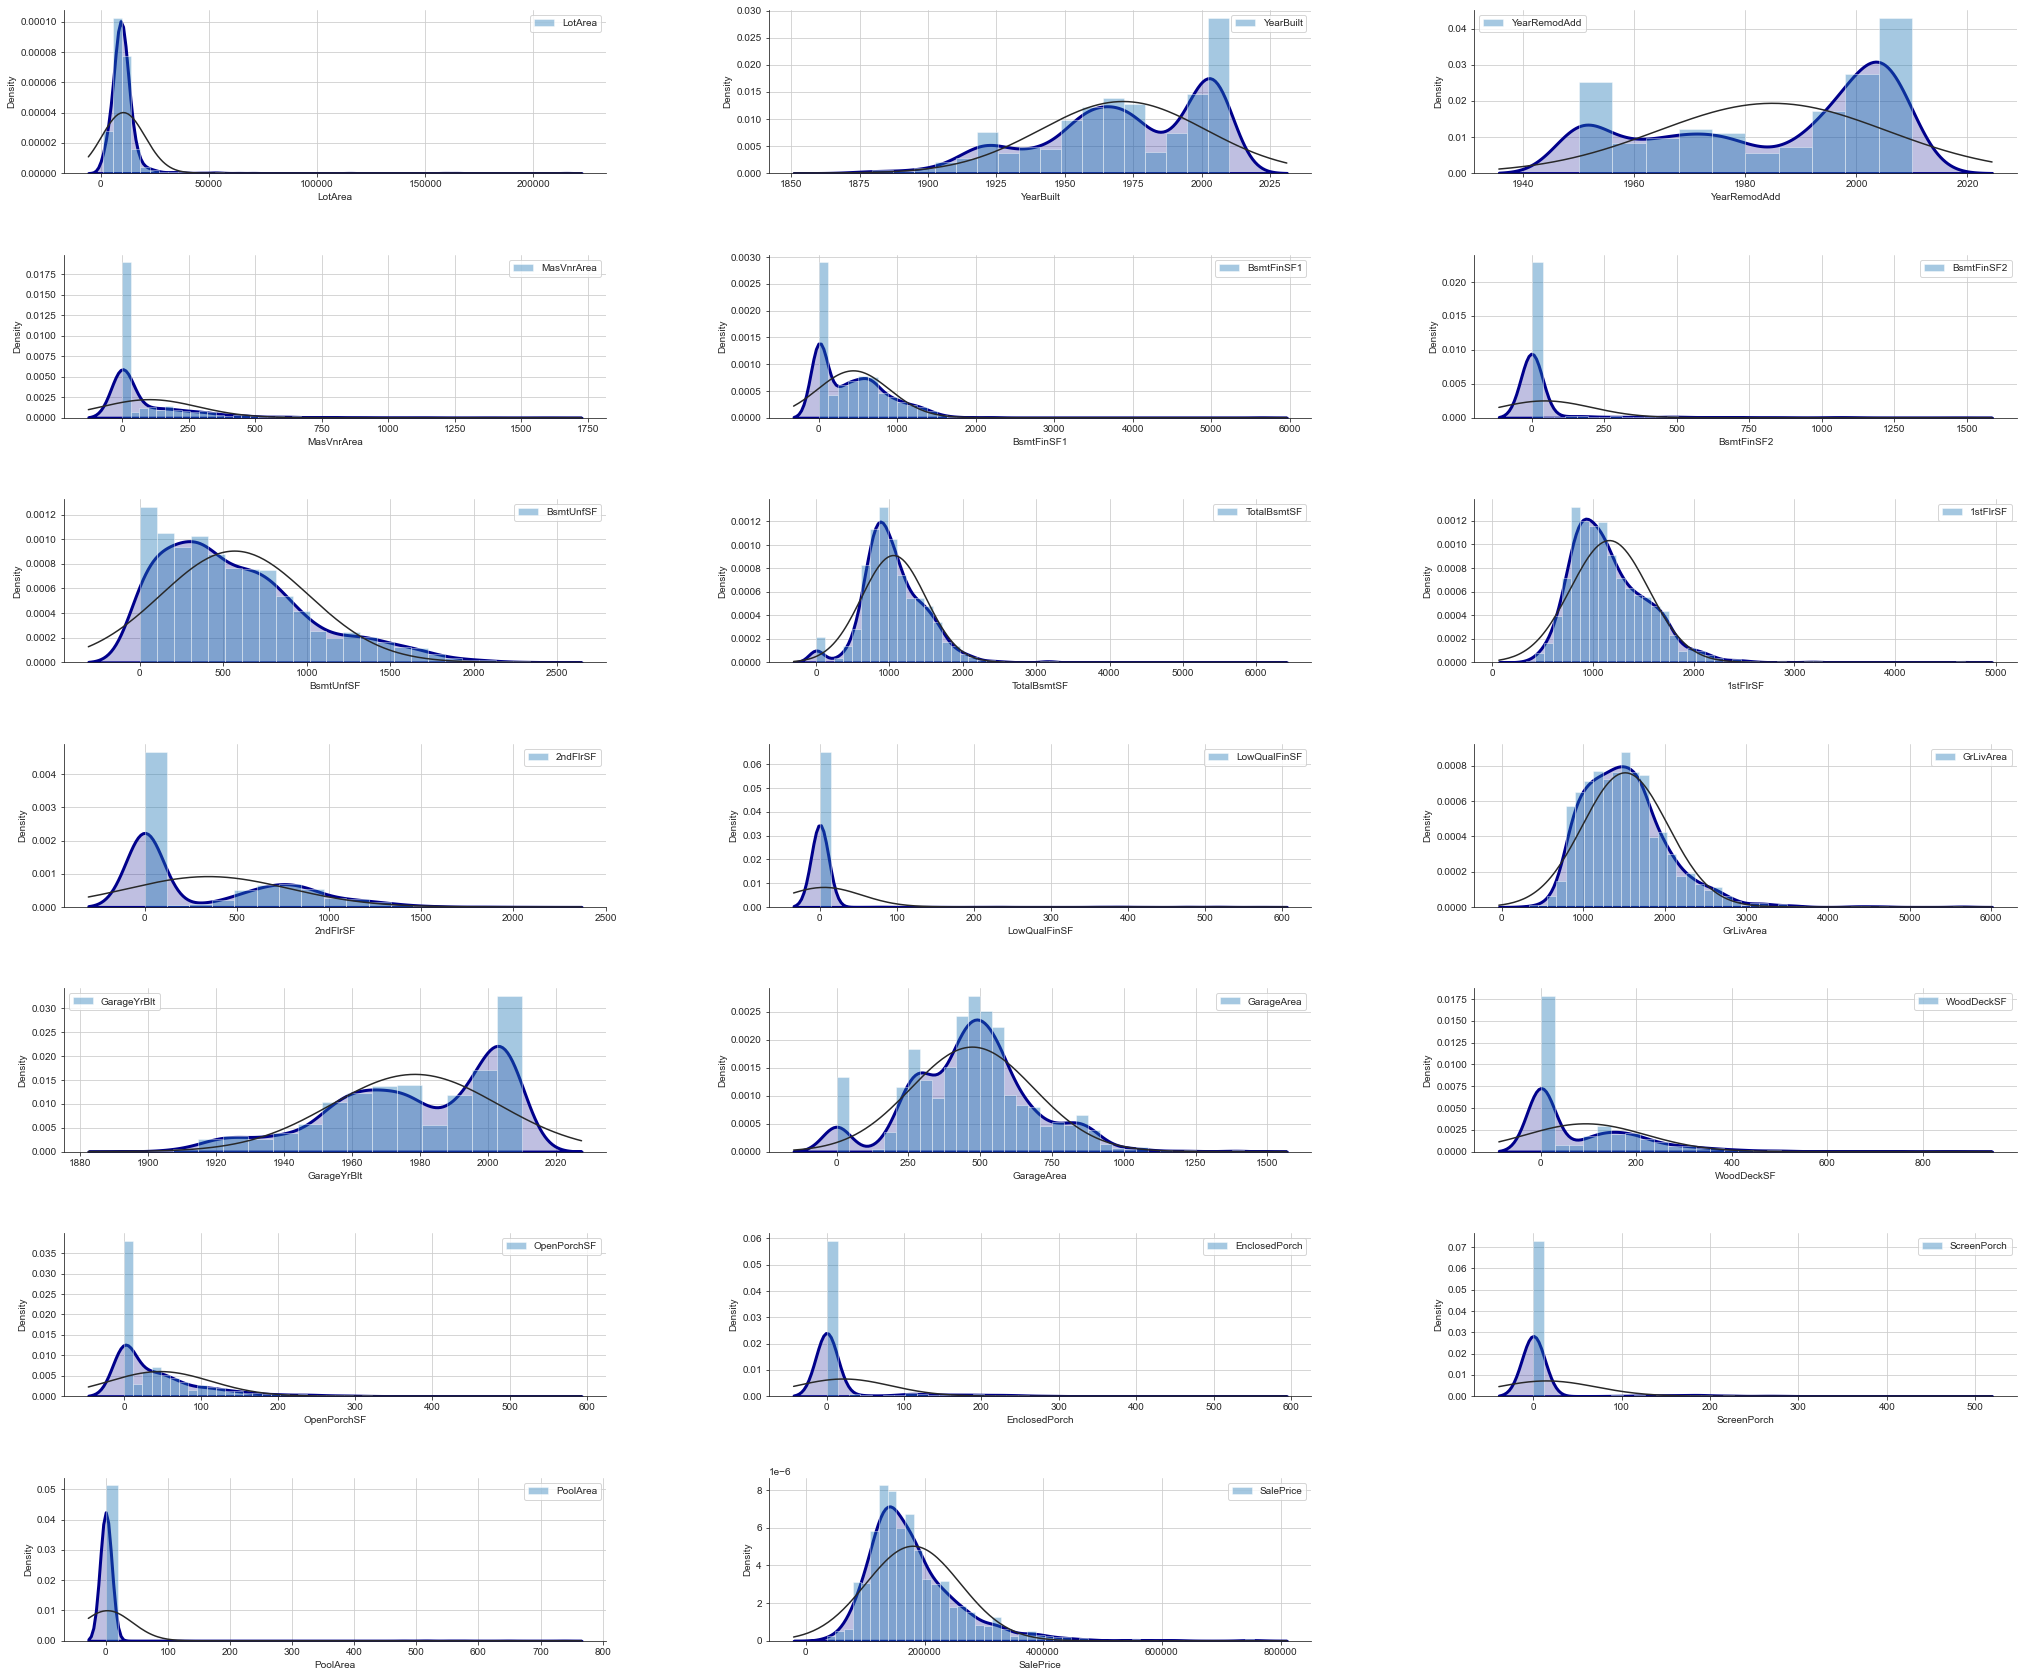

In [214]:
# plot the kde of numerical features
def plot_kde(data:pd.DataFrame):
    """
    Plot the kde of numerical features
        
    Parameters
    ----------
    data : DataFrame
    """

    figure = plt.figure(figsize=(35, int(len(data.columns)*1.5)))
    figure.subplots_adjust(wspace=0.3, hspace=0.5)
    

    for i, col in enumerate(data.columns, start=1):
        ax = figure.add_subplot(len(data.columns)//3 + 1, 3, i)
        sns.distplot(data[col], fit=stats.norm, hist=True, kde=True, 
                     kde_kws={'linewidth': 3, 'shade': True, 'color': 'darkblue'}, 
                     label=col, ax=ax)       

        sns.despine()
        plt.legend()

plot_kde(df_train[numerical_feats])


### Categorical variables

In [42]:
# plot countplot for categorical features
def plot_count_plot(data:pd.DataFrame):
    """
    Plot countplot for categorical features
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    """
    figure = plt.figure(figsize=(35, int(len(data.columns)*1.5)))
    figure.subplots_adjust(wspace=0.3, hspace=0.8)

    for i, col in enumerate(data.columns, start=1):
        ax = figure.add_subplot(len(data.columns)//3 + 1, 3, i)
        sns.countplot(x=col, data=data, ax=ax)
        sns.despine()
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        

# plot_count_plot(df_train[categorical_feat])

## Bivariate analysis

### Target - numerical vars

*In Summary:*

The most contributed numerical features in predicting the **SalePrice** are:
- TotalBsmtSF
- 2stFlrSF
- GrLivArea
- GarageArea

#### Scatter plot

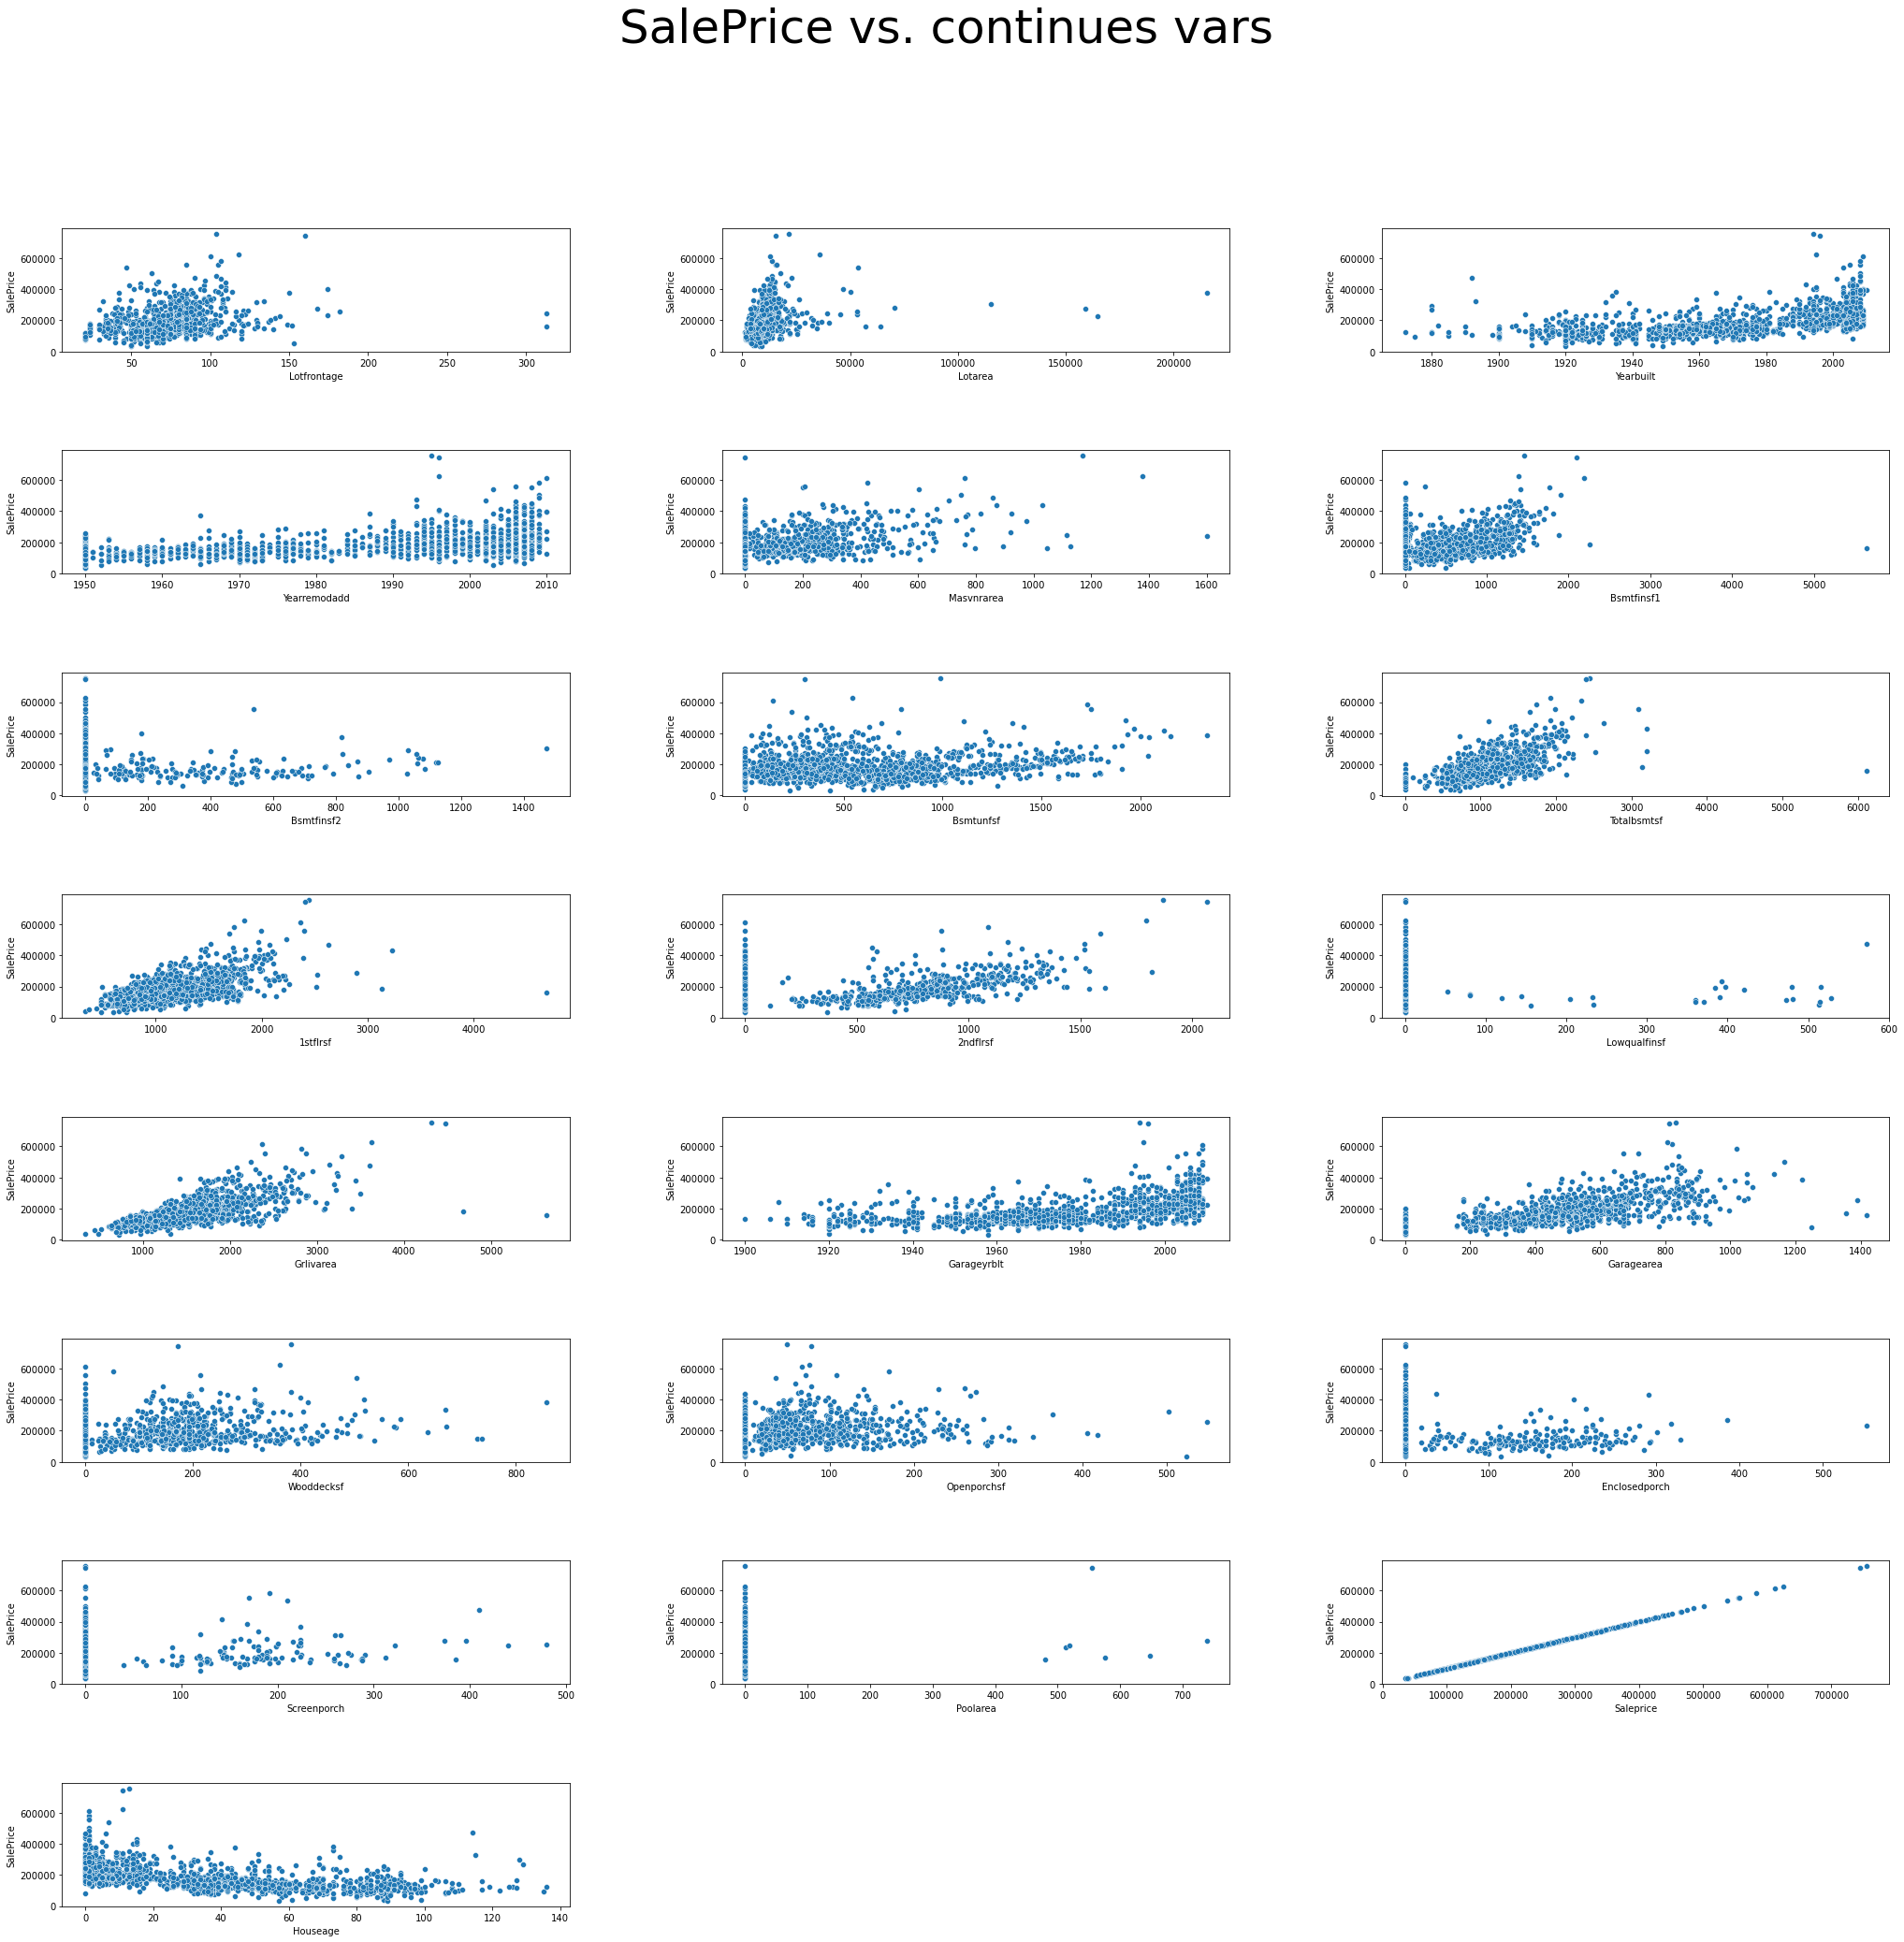

In [43]:
def plot_scatter_plot(data:pd.DataFrame, cols:list, comp_var:str, title:str):
    """
    Plot scatter plot between the comparison variable and continues variables
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    comp_var: str
    title: str
    """
    figure = plt.figure(figsize=(35, int(len(cols)*1.5)))
    figure.subplots_adjust(wspace=0.3, hspace=0.8)

    for i, col in enumerate(cols, start=1):
        ax = figure.add_subplot(len(cols)//3 + 1, 3, i)
        sns.scatterplot(x=col, y=comp_var, data=data, ax=ax)
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel(comp_var)

    figure.suptitle(title, fontsize=50)

plot_scatter_plot(data=df_train, cols=numerical_feats, comp_var='SalePrice', title='SalePrice vs. continues vars')

#### Correlation matrix
Based on the **univariate analysis**, spearman correlation coefficient is the best way to check the correlation between the variables because the data is not normally distributed.


From the correlation matrix, the pairs of features with high correlation are:
- YearBuilt: {GarageYrBlt: 0.891, HouseAge: -0.98},
- YearRemodAdd: {GarageYrBlt: 0.72},
- TotalBsmtSF: {1stFlrSF: 0.82},
- GrLivArea: {SalePrice: 0.73},

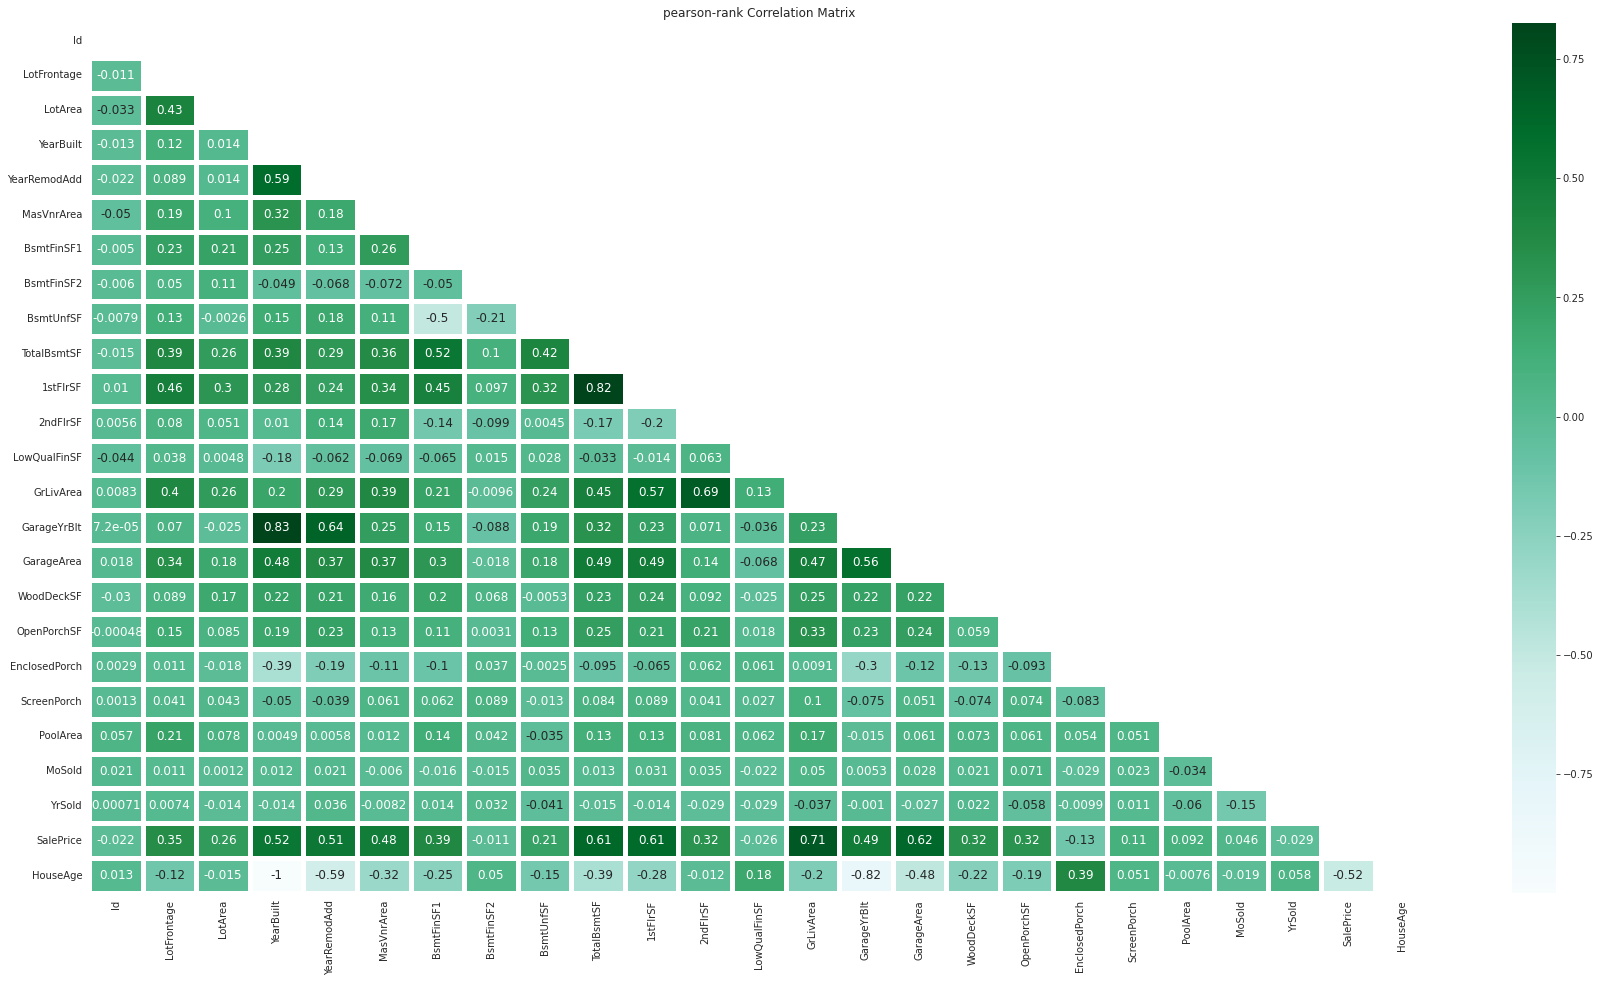

In [13]:
# Find the spearman correlation between features

def plot_corr_mat(data:pd.DataFrame, method='spearman'):
    corr_mat = data.corr(method=method) # corr method take only numeric vars


    mask = np.zeros_like(corr_mat)
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("whitegrid"): # white, dark, whitegrid, darkgrid, ticks
        f, ax = plt.subplots(figsize=(30, 16))
        ax = sns.heatmap(data=corr_mat, mask=mask, annot=True, annot_kws={'size':12}, linewidths=5, cmap=plt.cm.BuGn)
        ax.set_title(f'{method}-rank Correlation Matrix')

    return corr_mat

corr_mat = plot_corr_mat(data=df_train, method='pearson')

In [86]:
def find_corr_feat(corr_mat:pd.DataFrame,  threshold:float) -> pd.DataFrame:
    """
    Find correlated features that have correlation value bigger than the threshold
        
        Parameters
        ----------
        data : DataFrame
        threshold : float
        
        Returns
        -------
        correlated_feat : DataFrame contains correlated features
    """

    # Create dictionary holds correlation features
    correlated_features = defaultdict(dict)

    # we search for correlated values in triangular shape
    for col_ind, col_name in enumerate(corr_mat.columns):
        for row_ind in range(col_ind):
            corr_val = round(abs(corr_mat.iloc[row_ind, col_ind]), 3)
            if(corr_val < threshold):
                continue
            correlated_features[col_name][corr_mat.index[row_ind]] = corr_val
        
    return correlated_features

print("The most correlate features are:\n ", find_corr_feat(corr_mat, 0.65))


The most correlate features are:
  defaultdict(<class 'dict'>, {'1stFlrSF': {'TotalBsmtSF': 0.82}, 'GrLivArea': {'2ndFlrSF': 0.688}, 'GarageYrBlt': {'YearBuilt': 0.826}, 'SalePrice': {'GrLivArea': 0.709}, 'HouseAge': {'YearBuilt': 0.999, 'GarageYrBlt': 0.825}})


### Target - categorical vars
*In Summary:*

The most contributed categorical features in predicting the **SalePrice** are:
- Neighborhood
- Condition2
- OverallQual
- OverallCond
- RoofMatl
- Exterior2nd
- ExtraQual
- BsmtQual
- BsmtCond
- HeatingQC
- FullBath
- KitchenQuall
- TotRmsAbvGrd
- FireplaceQu
- GarageType
- GarageCars
- PoolQC

In [215]:
def calc_agg(data:pd.DataFrame, groupby_col:str, target_col:str, agg_val:str):

    """
    Groupe data by groupby_col and calculate the median value and calculate aggregate value for each category groupby_column
    """
    df_agg = data.groupby(groupby_col).agg(agg_val)[target_col].to_frame()

    # Make index values as groupby_column
    df_agg[groupby_col] = df_agg.index

    # Change median value groupby_column name
    df_agg.rename(columns={target_col:agg_val}, inplace=True)
    
    # Reset the index
    df_agg.reset_index(drop=True, inplace=True)

    # Change type of the category groupby_column to string
    df_agg[groupby_col] = df_agg[groupby_col].astype(str)

    # Sort dateframe by value of category groupby_column
    df_agg = df_agg.sort_values(by=agg_val)

    return df_agg


#### Bar plot \w mean

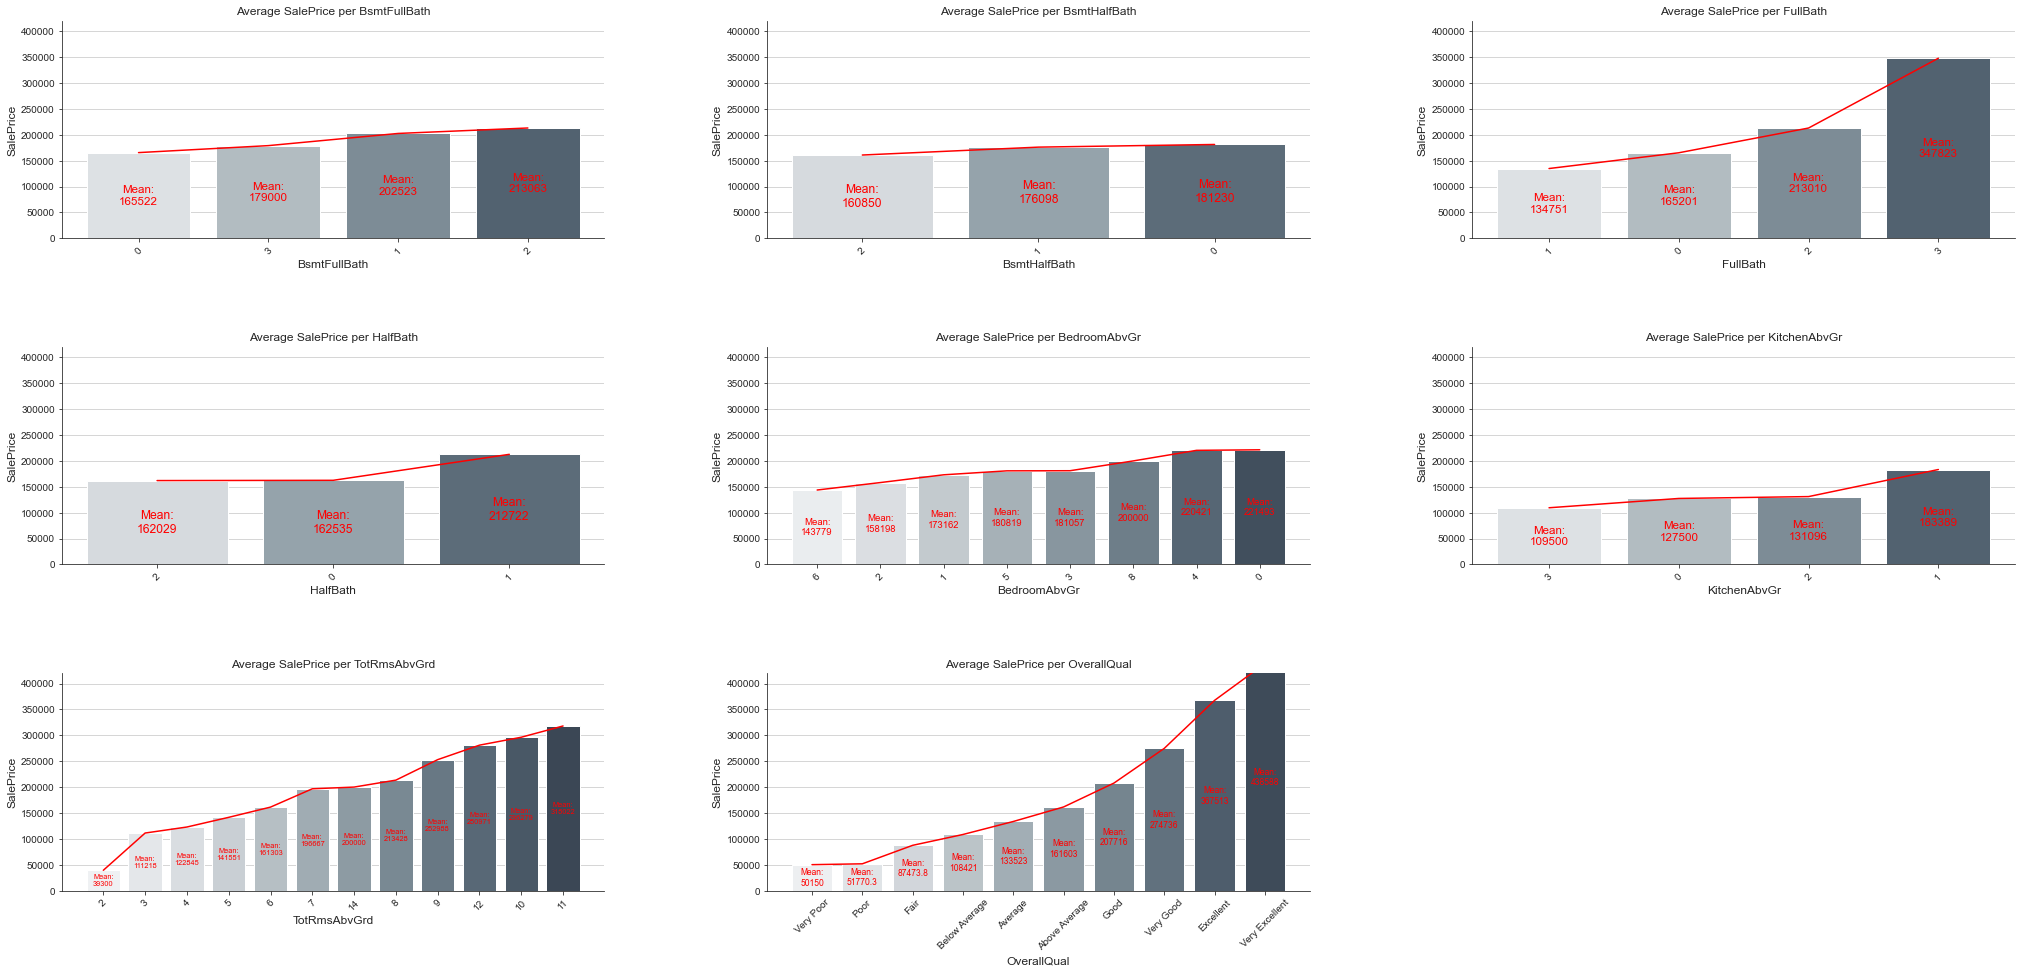

In [218]:
def plot_mean_count_plot(data:pd.DataFrame, cols:list, comp_var:str, title:str):
    """
    Plot mean of comparison variable grouped by categorical features as scatter plot
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    comp_var : str
    """
    # figure, axs = plt.subplots(nrows=len(cols), ncols=1, figsize=(15, len(cols)*9))

    figure = plt.figure(figsize=(35, int(len(cols)*2)))
    figure.subplots_adjust(wspace=0.3, hspace=0.5)

    # for i, col in enumerate(cols):

    # plot the bar of categorical variables
    for i, col in enumerate(cols, start=1):
        ax = figure.add_subplot(len(cols)//3 + 1, 3, i)

        df_means = calc_agg(data, col, comp_var, agg_val='mean')

        bar_axs = sns.barplot(x=col, y='mean', data=df_means, order=df_means[col], palette="Blues", saturation=0.2, ci=None, ax=ax)
        sns.lineplot(x=col, y='mean', data=df_means, color='red', ax=ax)

        # Adjust labels size to the number of x-ticks and x-lim
        lbl_font_size = -22.4*ax.get_xlim()[1] + 23*len(ax.get_xticks())

        # Label each bar by its value
        ax.bar_label(bar_axs.containers[-1], label_type='center', fmt="Mean:\n%g", fontsize=lbl_font_size, color='red')
        ax.set_title(f"Average {comp_var} per {col}")
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel(comp_var, fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim([0, 420_000])
        sns.set_style("ticks", {'axes.grid' : True})

        sns.despine()

    # figure.suptitle(title, fontsize=50)


cols = categorical_feat
plot_mean_count_plot(data=df_train, cols=cols, comp_var= 'SalePrice', title='Mean price per category')

#### Box-whisker \w mean

MSSubClass SalePrice


KeyError: 'SalePrice'

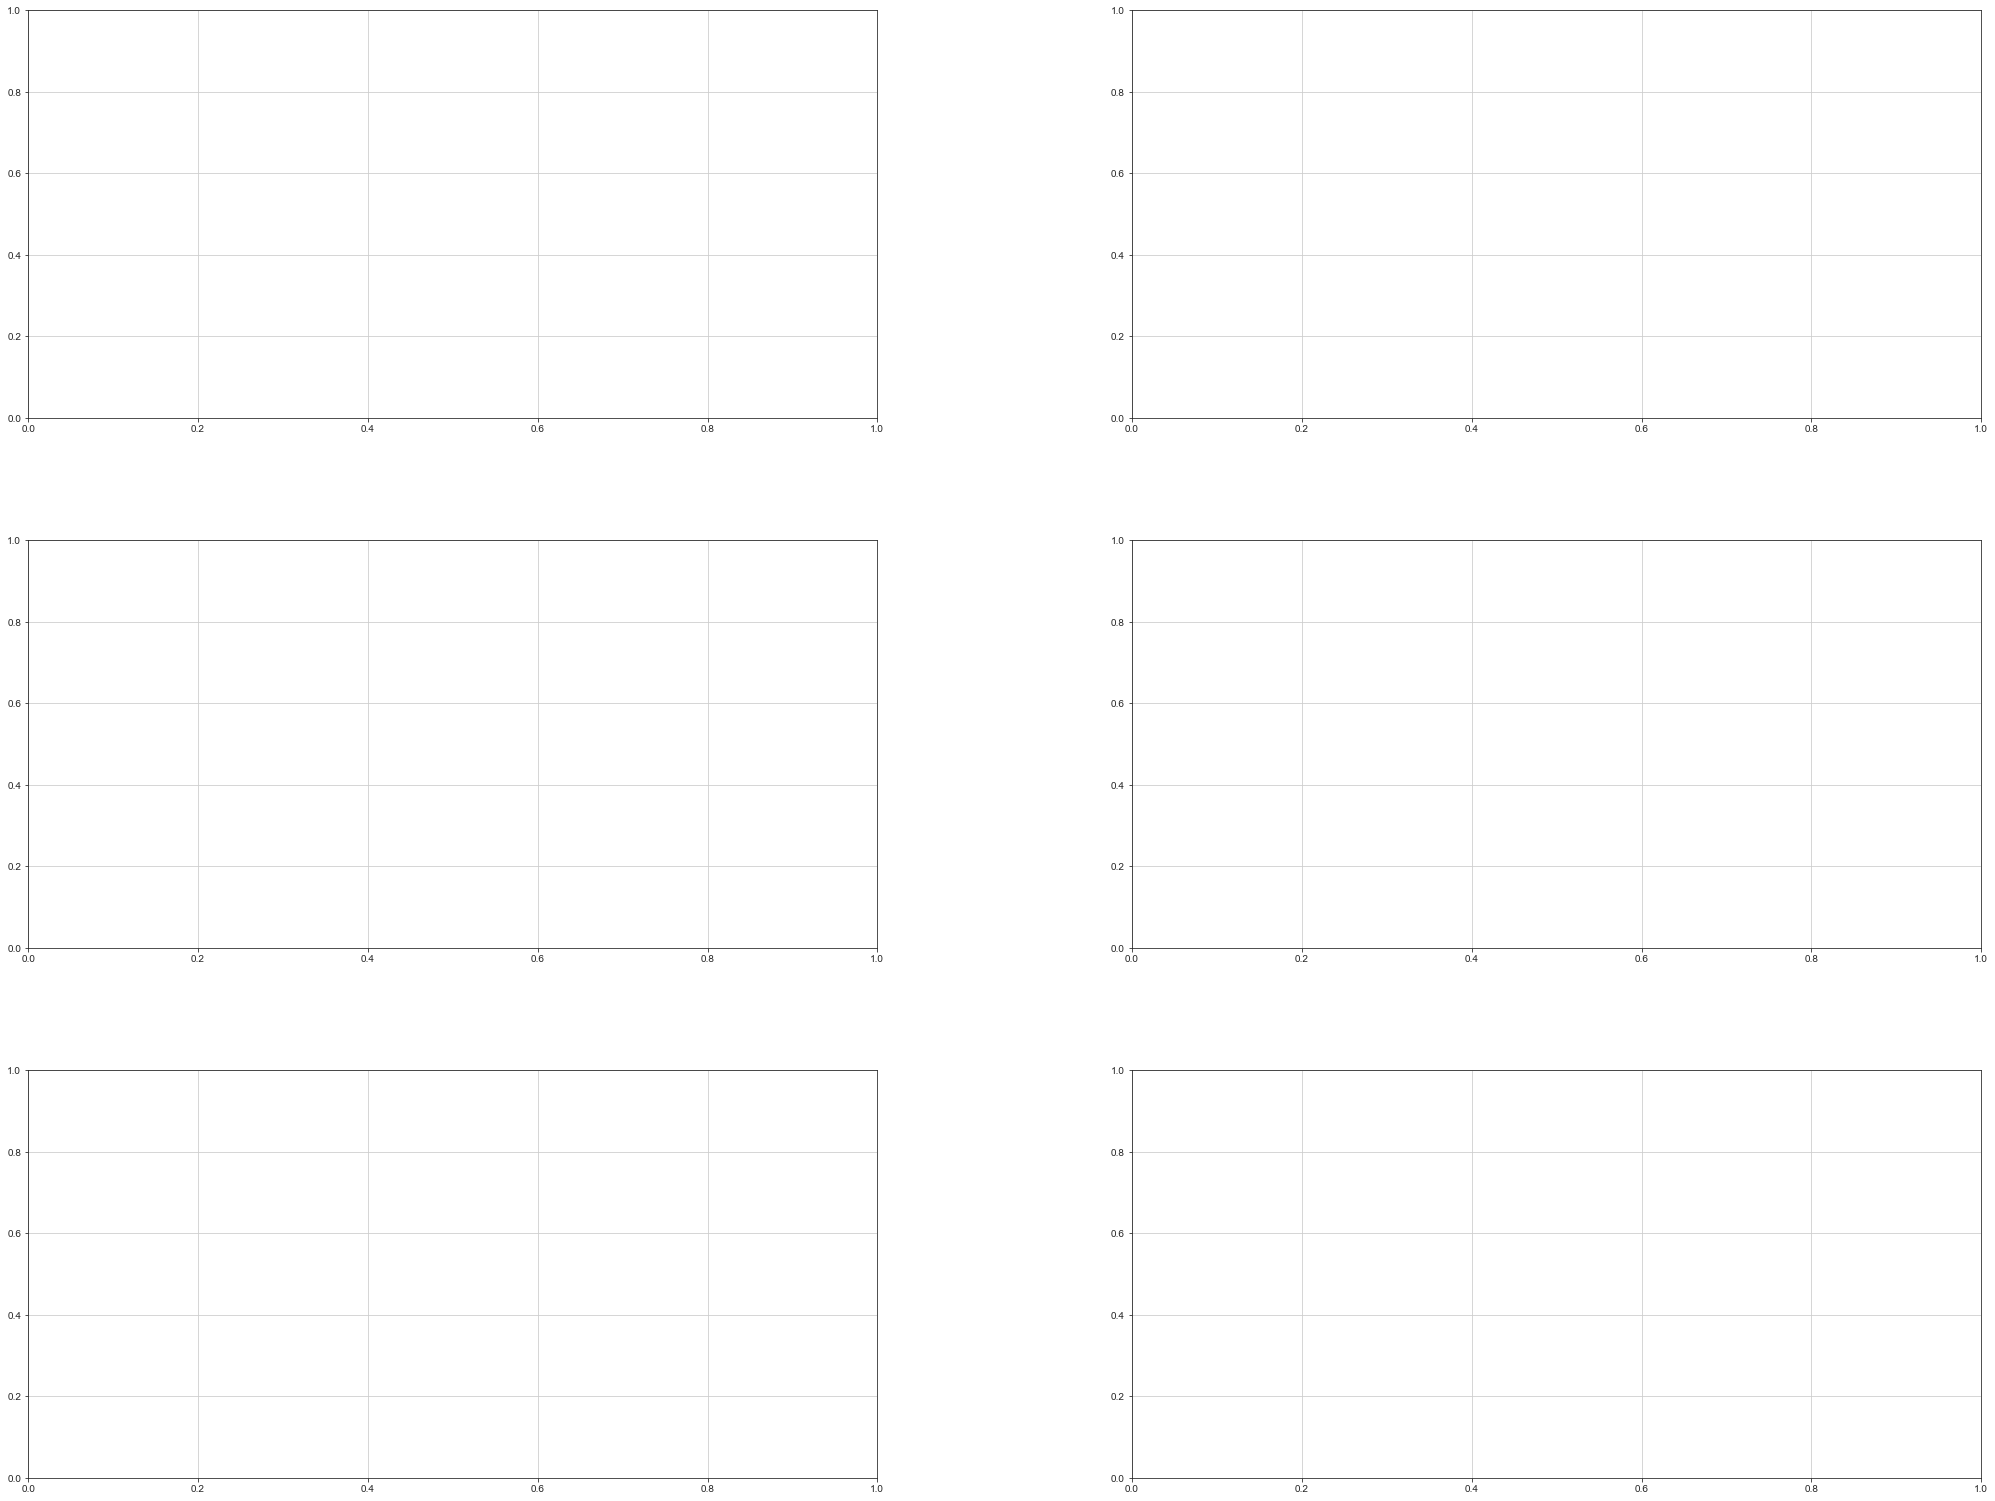

In [40]:
def plot_mean_box_plot(data:pd.DataFrame, features:list[str], comp_var:str, title:str=None):
    """
    Plot mean of comparison variable grouped by categorical features as scatter plot
    
    Parameters
    ----------
    data : DataFrame
    features : list of features
    comp_var : str
    """

    figure, axs = plt.subplots(nrows=len(features), ncols=2, figsize=(35, len(features)*9))

    # Reshape the axs to 2 dimension array if the features list is 1 dimension.
    axs = np.reshape(axs, (-1, 2))

    figure.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(features):
        
        df_medians = calc_agg(data=data, groupby_col=col, target_col=comp_var, agg_val='median')

        print(df[col])
        # Draw box-whisker plot 
        box_plot = sns.boxplot(x=col, y=comp_var, data=data, order=df_medians[col], palette='viridis', ax=axs[i][0])

        # # Put text on the median line
        # for xtick in box_plot.get_xticks():
        #     box_plot.text(x=xtick, y=df_medians.loc[xtick, 'median']+0.2, s=str(df_medians.loc[xtick, 'median']), 
        #             horizontalalignment='center',size='x-small',color='w',weight='semibold')

        axs[i][0].set_title(f'{comp_var} vs. {col}')
        axs[i][0].set_ylabel(comp_var)


        # Draw points that represent median value in each category
        sns.scatterplot(x=col, y='median', data=df_medians, s=150, color='red', ax=axs[i][1])

        # Draw trend line that represent 
        sns.lineplot(x=col, y='median', data=df_medians, size=9, ax=axs[i][1])

        
        # # Put text on the median points
        # for point_x, point_y in zip(df_medians[col].to_list(), df_medians['median'].to_list()):
        #     axs[i][1].text(point_x, point_y, str(round(point_y,2)), horizontalalignment='left', size='medium', color='black', weight='semibold')

        axs[i][1].set_title(f"{comp_var}'s median per {col}")
        axs[i][1].set_xlabel(col, fontsize=12)
        axs[i][1].set_ylabel(comp_var, fontsize=12)
        axs[i][1].set_xticklabels(df_medians[col])
        axs[i][1].set_ylim(axs[i][0].get_ylim())
        
        sns.despine()

    # figure.suptitle(title, fontsize=50)

plot_mean_box_plot(data=df_train, features=categorical_feat[:3], comp_var= 'SalePrice', title='Mean price per category')

### Binning
After preprocessing and creating new columns. The new **age** & **age_renovated** columns aren't make good pattern for predicting the price.

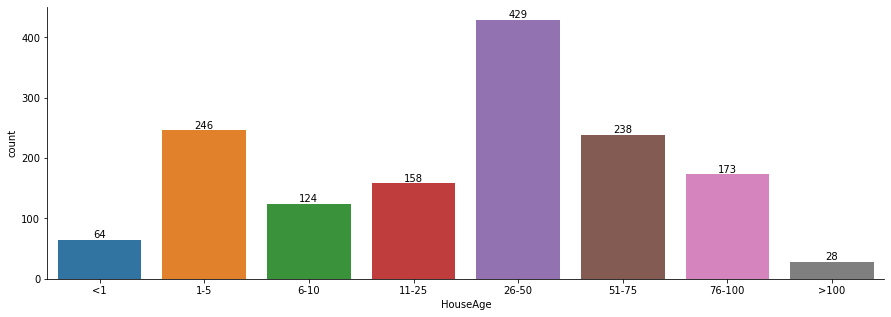

In [181]:
# binned those new features for categorizing
bins = [-2,0,5,10,25,50,75,100,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']

df_train_binned = df_train.copy()


df_train_binned['HouseAge_binned'] = pd.cut(df_train['HouseAge'], bins=bins, labels=labels)

# histograms for the binned columns
f, axes = plt.subplots(1, 1,figsize=(15,5))
p1=sns.countplot(df_train_binned['HouseAge_binned'],ax=axes)
axes.bar_label(p1.containers[-1]) 


sns.despine()
axes.set(xlabel='HouseAge')
axes.yaxis.tick_left()



### Encoding

[[<AxesSubplot:> <AxesSubplot:>]]


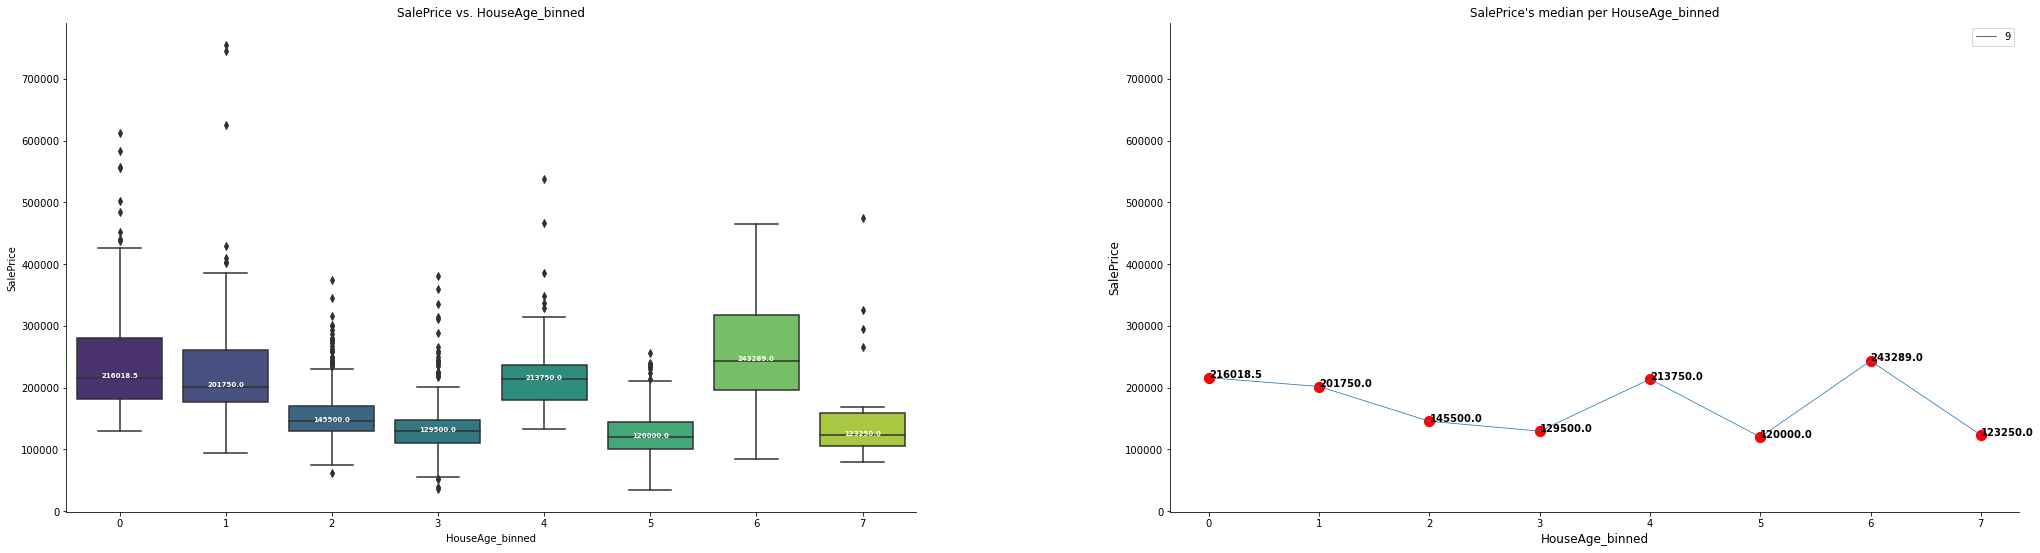

In [185]:
encoder = LabelEncoder()
df_train_binned['HouseAge_binned'] = encoder.fit_transform(df_train_binned['HouseAge_binned']).astype(str)

plot_mean_box_plot(df_train_binned, cols=['HouseAge_binned'], comp_var='SalePrice', title='')

## Multivariate

In [55]:
# sns.pairplot(data=df_train[numerical_feat], corner=True, palette='RdYlGn')

## Outliers checking

### Using Box-whisker plot
*Outliers:*
- LotFrontage > 300
- LotArea > 100,000
- BsmtFinSF1 > 5,000
- BsmtFinSF2 > 1,400
- TotalBsmtSF > 6,000
- 1stFlrSF > 4,000
- GrLivArea > 4,000
- GarageArea > 1,300
- WoodDeckSF > 800
- EnclosedPorch > 500
- SalePrice > 700,000

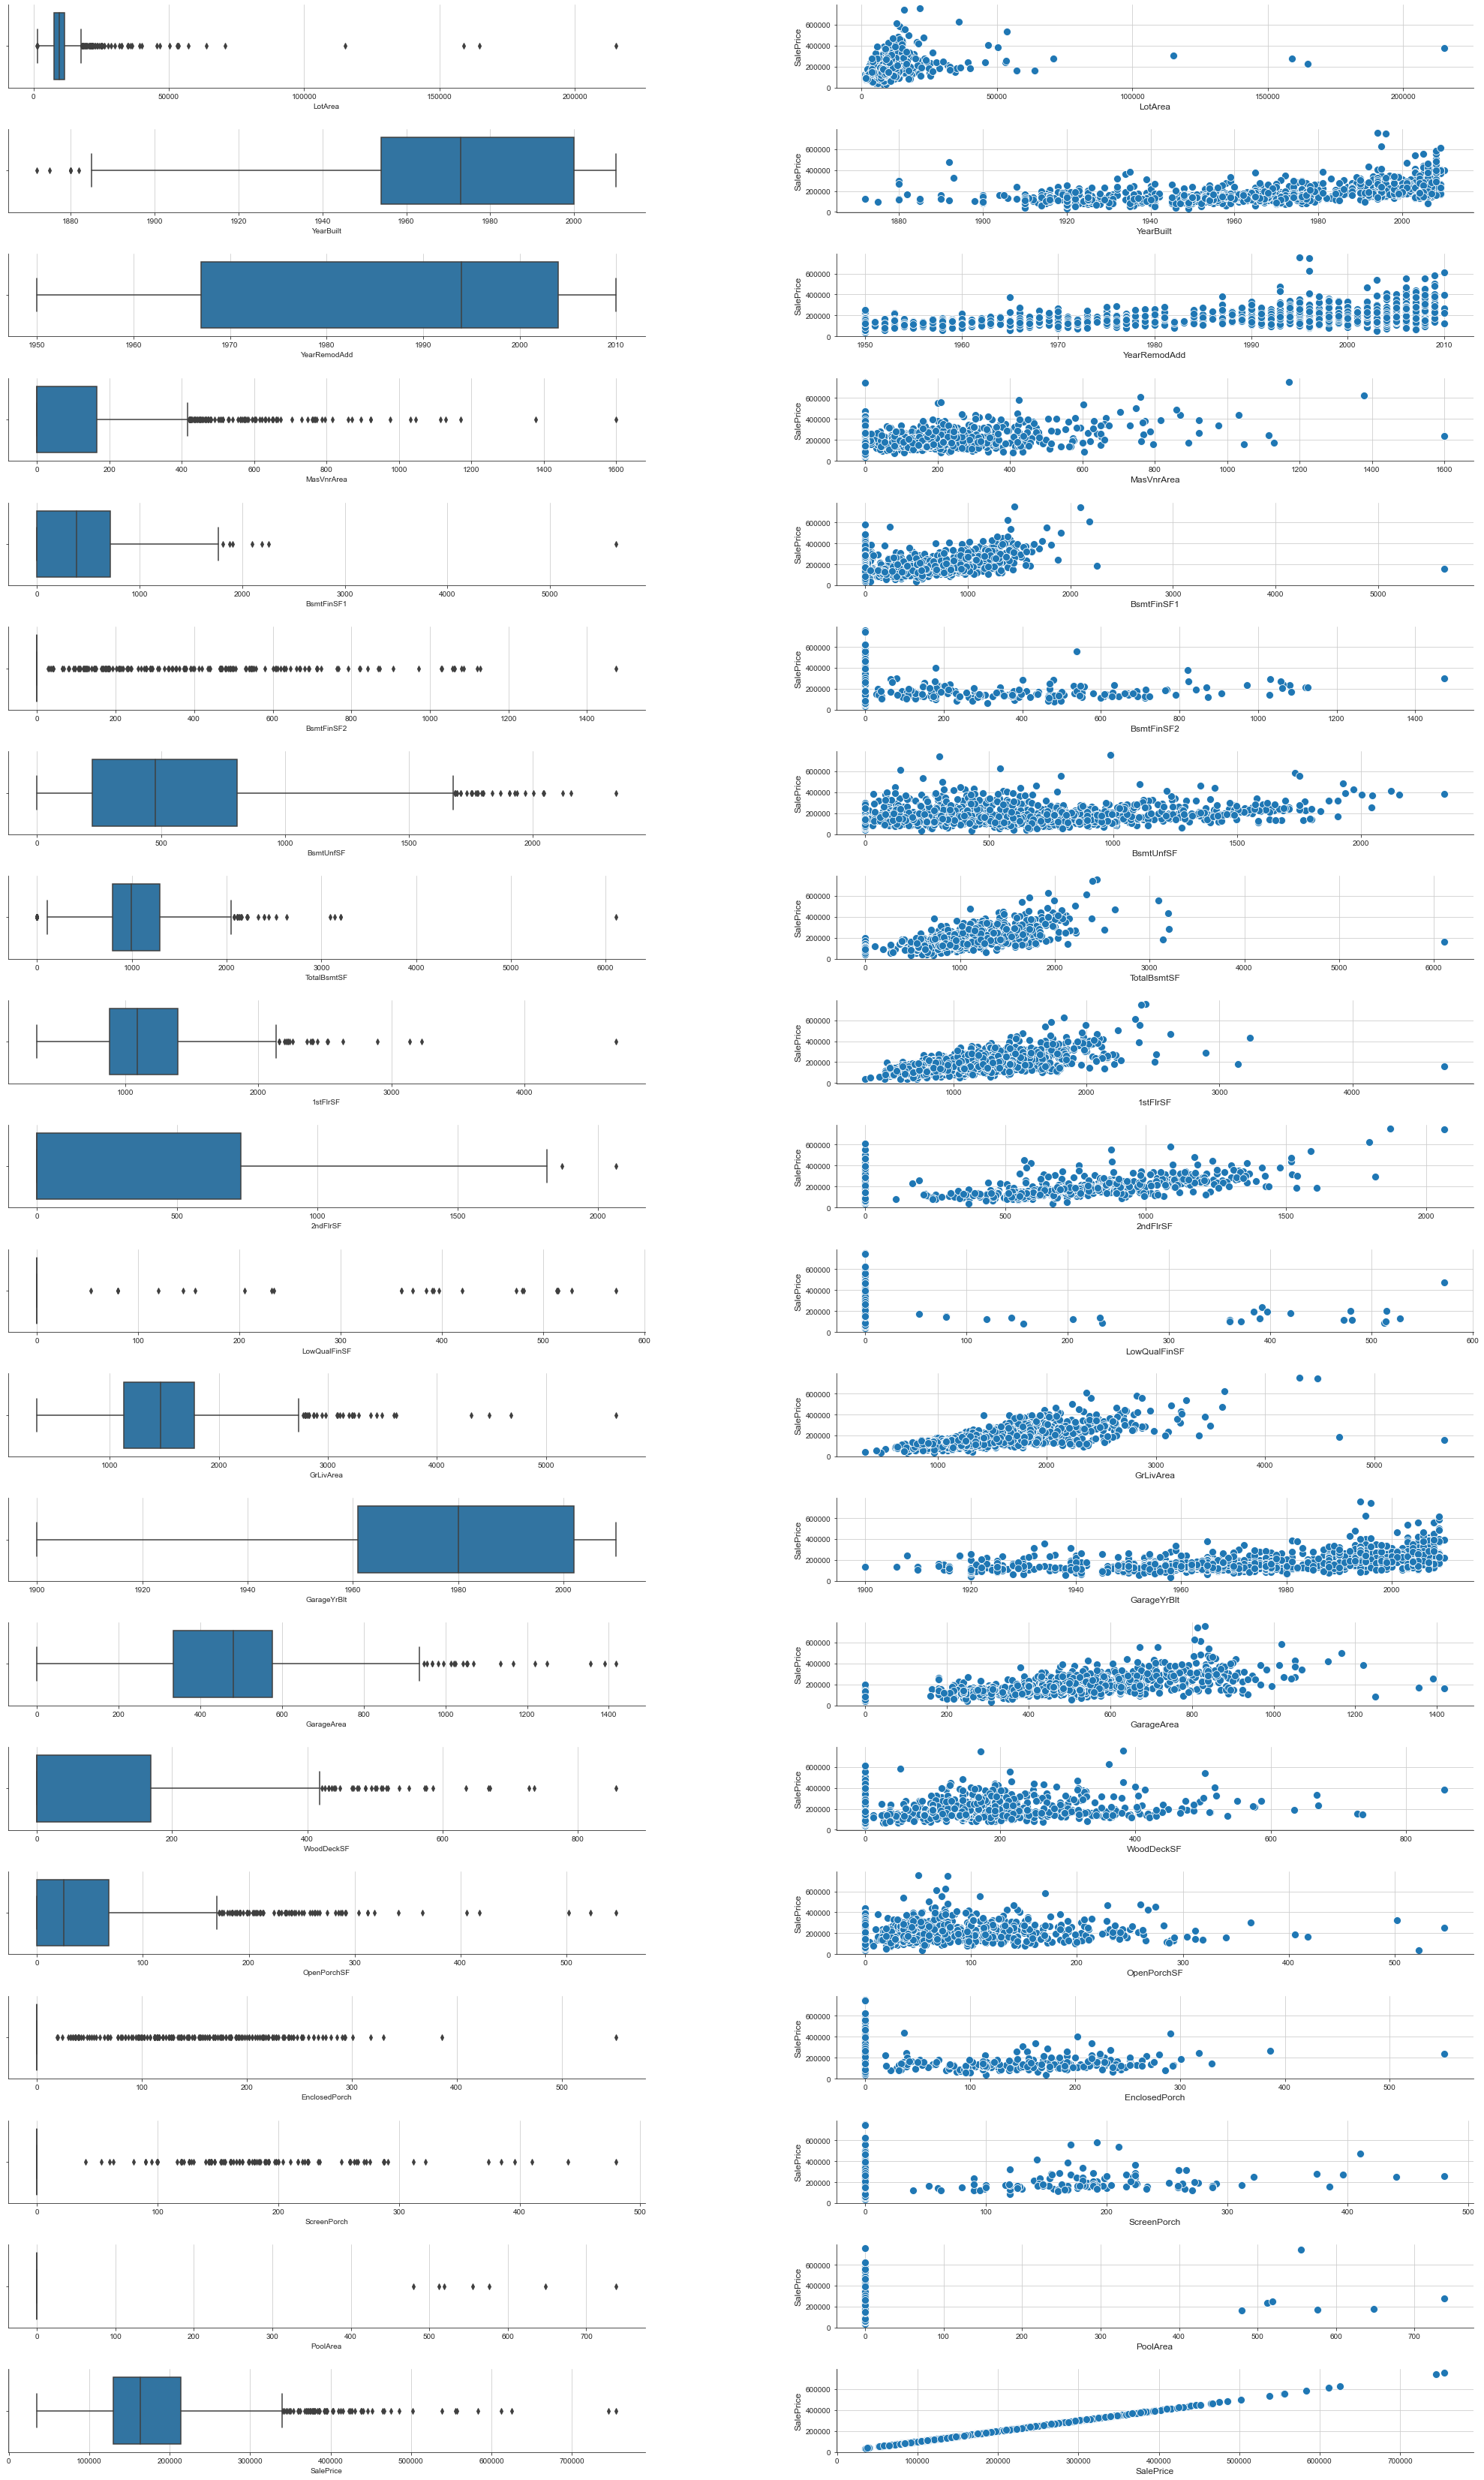

In [219]:
def plot_box_whisker_scatter(data:pd.DataFrame, comp_var:str):
    """
    Plot box-whisker and scatter plot for numerical features
    
    Parameters
    ----------
    data : DataFrame
    comp_var: str
    """
  
    figure, axs = plt.subplots(nrows=len(data.columns), ncols=2, figsize=(35, int(len(data.columns)*3)))
    figure.subplots_adjust(wspace=0.3, hspace=0.5)

    for i, col in enumerate(data.columns):
        sns.boxplot(x=col, data=data, ax=axs[i][0])

        sns.scatterplot(x=col, y=comp_var, data=data, ax=axs[i][1], s=100)
        
        axs[i][1].set_xlabel(col, fontsize=12)
        axs[i][1].set_ylabel(comp_var, fontsize=12)
        sns.despine()
        
plot_box_whisker_scatter(data=df_train[numerical_feat], comp_var='SalePrice')



### Using percentile

In [220]:
def detect_outliers_percentile(series:pd.Series):
    quartile_10, quartile_90 = series.quantile([0.1, 0.9])
 
    dropped_index = series[(series < quartile_10) | (series > quartile_90)].index
    return dropped_index

# outliers_perc = detect_outliers_percentile(df_train['SalePrice'])

### Manual detecting

In [10]:
def detect_outliers_manual(data:pd.DataFrame) -> list[pd.Index]:
    indexes = data.query(
                """
                LotArea > 100_000 | \
                BsmtFinSF1 > 5_000 | \
                BsmtFinSF2 > 1_400 | \
                TotalBsmtSF > 6_000 | \
                GrLivArea > 4_000 | \
                GarageArea > 1_300 | \
                WoodDeckSF > 800 | \
                EnclosedPorch > 500 | \
                SalePrice > 700_000 
                """
            ).index

    return indexes 

# Data Preprocessing 

In [11]:
# Change missing values in some features to corresponding values given in data description file

def fill_missing_vals(data:pd.DataFrame) -> pd.DataFrame:

    cat_fill_missing_vals = {
        'PoolQC': 'No Pool',
        'Fence': 'No Fence',
        'MiscFeature': 'None',
        'Alley':'No alley access',
        'FireplaceQu' : 'No Fireplace',
        'GarageFinish' : 'No Garage',
        'GarageCond' : 'No Garage',
        'GarageQual' : 'No Garage',
        'GarageType' : 'No Garage',
        'BsmtExposure' : 'No Basement',
        'BsmtFinType2' : 'No Basement',
        'BsmtQual' : 'No Basement',
        'BsmtCond' : 'No Basement',
        'BsmtFinType1' : 'No Basement',
        'MasVnrType' : 'None',
    }

    # for col, fill_val in cat_fill_missing_vals.items():
    #     data[col] = data[col].fillna(fill_val)
    cols = list(cat_fill_missing_vals.keys())
    data[cols] = data[cols].apply(lambda col: col.fillna(cat_fill_missing_vals[col.name]))

    # Remove Electrical feature
    droped_index = data[data['Electrical'].isnull()].index
    data.drop(index=droped_index, inplace=True)


    # Fill by mean for MasVnrArea feature
    data['MasVnrArea'] = data.groupby(by='MasVnrType')['MasVnrArea'].transform(
    lambda x: x.fillna(x.mean())
    )
    
    # Drop LotFrontage & GarageYrBlt features
    data = data.drop(columns=['LotFrontage','GarageYrBlt'])
    
    return data

def remove_duplicates(data:pd.DataFrame) -> pd.DataFrame:
    """ Remove duplicates values if exist"""
    data = data.drop_duplicates()
    return data

def remove_outliers(data:pd.DataFrame, indexes:list[pd.Index]) -> pd.DataFrame:
    """Remove outliers for the given indexes"""
    return data.drop(index=indexes)


df_train_modified = remove_duplicates(fill_missing_vals(df_train_not_edit))
df_train_modified = remove_outliers(data=df_train_modified, indexes=detect_outliers_manual(df_train_modified))
categorical_feats_modified, numerical_feats_modified = split_features_by_type(df_train_modified)


df_test_modifid = fill_missing_vals(df_test_not_edit)

# Categorical Encoding
- For nominal features, will apply One-Hot Encoding
- For Ordinal features, will apply Ordinal Encoding

In [12]:
# Split categorical features based on nominal and ordinal features
cat_nominal_features = {
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','SaleCondition',
    'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating','CentralAir', 'Electrical', 'Condition1',
    'Condition2', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Functional', 'Fireplaces',
    'GarageType', 'GarageFinish', 'PavedDrive', '3SsnPorch', 'MiscFeature', 'SaleType'
}
cat_ordinal_features = {
    'BsmtCond',
    'BsmtExposure',
    'BsmtQual',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'GarageCars',
    'GarageCond',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'MiscVal',
    'MoSold',
    'PoolQC',
    'YrSold'
}

# Split categorical features based on numeric and string vals
cat_num_vals = {'KitchenAbvGr', 'HalfBath', 'BedroomAbvGr', 'FullBath', 'BsmtHalfBath', 'BsmtFullBath', 'TotRmsAbvGrd' , 'Fireplaces', 'MoSold', 'GarageCars', 'YrSold', '3SsnPorch', 'MSSubClass', 'MiscVal'}
cat_str_vals = {
    'Alley',
    'BldgType',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'Condition1',
    'Condition2',
    'Electrical',
    'ExterCond',
    'ExterQual',
    'Exterior1st',
    'Exterior2nd',
    'Fence',
    'FireplaceQu',
    'Foundation',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'Heating',
    'HeatingQC',
    'HouseStyle',
    'KitchenQual',
    'LandContour',
    'LandSlope',
    'LotConfig',
    'LotShape',
    'MSZoning',
    'MasVnrType',
    'MiscFeature',
    'Neighborhood',
    'PavedDrive',
    'PoolQC',
    'RoofMatl',
    'RoofStyle',
    'SaleCondition',
    'SaleType',
    'Street',
    'Utilities'
}

cat_str_ordinal_vals = list(cat_str_vals - cat_nominal_features)
cat_str_nominal_vals = list(cat_str_vals - cat_ordinal_features)

In [13]:
def encode_cat_feats(data:pd.DataFrame):

    # Label encoding for the ordinal categorical features
    str2num_values = {
        'ExterQual': {'Po':0, 'Fa':1, 'TA':2, 'Gd':3 ,'Ex':4},
        'ExterCond': {'Po':0, 'Fa':1, 'TA':2, 'Gd':3 ,'Ex':4},
        'PoolQC': {'No Pool':0, 'Fa':1, 'TA':2, 'Gd':3 ,'Ex':4},
        'FireplaceQu': {'Wall':0, 'OthW':1, 'Grav':2, 'GasW':3 ,'GasA':4, 'Floor':5},
        # 'Condition2': {0:'RRAe', 1:'RRNe', 2:'PosA', 3:'PosN' ,4:'RRAn', 5:'RRNn', 6:'Norm', 7:'Feedr', 8:'Artery'},
        'BsmtCond': {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3 ,'Gd':4,'Ex':5},
        'GarageQual': {'No Garage':0, 'Po':1, 'Fa':2, 'TA':3 ,'Gd':4,'Ex':5},
        'Fence': {'No Fence':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3 ,'GdPrv':4},
        'BsmtQual': {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3 ,'Gd':4,'Ex':5},
        'GarageCond': {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3 ,'Gd':4,'Ex':5},
        'HeatingQC': {'Po':0, 'Fa':1, 'TA':2, 'Gd':3 ,'Ex':4},
        'KitchenQual': {'Po':0, 'Fa':1, 'TA':2, 'Gd':3 ,'Ex':4},
        'BsmtExposure': {'No Basement':0, 'No':1, 'Mn':2, 'Av':3 ,'Gd':4}
    }

    cols = list(str2num_values.keys())
    data[cols] = data[cols].apply(lambda col: col.replace((str2num_values[col.name])))
    
    # Create dummies variables for the nominal categorical features
    data = pd.get_dummies(data=data, drop_first=True)

    print(data.shape)

    return data

df_train_modified = encode_cat_feats(df_train_modified)
df_test_modifid = encode_cat_feats(df_test_modifid)

(1446, 230)
(1459, 214)


# Feature Engineering

# Train/Test split

In [68]:
X_train, y_train = df_train_modified.drop(columns=['Id','SalePrice']), df_train_modified['SalePrice']
X_test, X_test_Id = df_test_modifid.drop(columns=['Id']), df_test_modifid['Id']

## Selection

In [71]:
@dataclass
class TestResult:
    """class for storing test results"""
    specs: list[str]
    scores: list[Union[int, float]]
    res: pd.DataFrame = field(init=False, repr=False)

    def __post_init__(self):
        # Grouping results in DataFrame
        self.res = pd.DataFrame()
        self.res['Specs'] = self.specs
        self.res['Score'] = self.scores

@dataclass
class FeatureRank:
    """
    class for holding feature ranking
    """

    func: Callable[[pd.DataFrame, pd.DataFrame], list[float]]
    X: pd.DataFrame
    y: pd.DataFrame
    test_result: TestResult = field(init=False)


    
    def __post_init__(self):
        """Call it after initialize a new instance"""
        
        # Calculate feature ranking
        score_vals, feats = self.func(self.X, self.y)
        
        # Create test result
        ranks = score_vals[0] if(len(score_vals)==2) else score_vals

        # Normalize ranks
        ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())

        self.test_result = TestResult(feats, ranks)

        # Change the index of the DataFrame
        self.test_result.res.index = [self.X.columns.get_loc(spec) for spec in self.test_result.res['Specs']]
    
    def get_largest_score(self, n:Union[int, str] = 'auto') -> list[str]:
        """Get the largest n scores"""
        if(isinstance(n, str) and n=='auto'):
            n = self.test_result.res.shape[0]
        
        return self.test_result.res.nlargest(n, columns=['Score'])['Specs'].values

    def feat_imp_plot(self, title, sorting=False):
        """Plot feature importance as bar plot"""

        # Take copy of result to avoid modifying on original result
        result = self.test_result.res.copy()
        
        if(sorting):
            result = result.sort_values(by='Score', ascending=False)
            
        fig = plt.figure(figsize=(20,8))
        ax  = fig.add_subplot()
        axs = sns.barplot(x='Specs', y='Score', data=result, palette = 'viridis', ax=ax)

        # Add rank values as annotation to bars 
        for p in axs.patches:
            axs.annotate('{:.2f}'.format(p.get_height()), (p.get_x(), p.get_height()))
        plt.box(False)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('\n Features')
        ax.set_ylabel('Importance \n')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=30)

        return ax

        

### Correlation

<AxesSubplot:title={'center':'Correlation - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

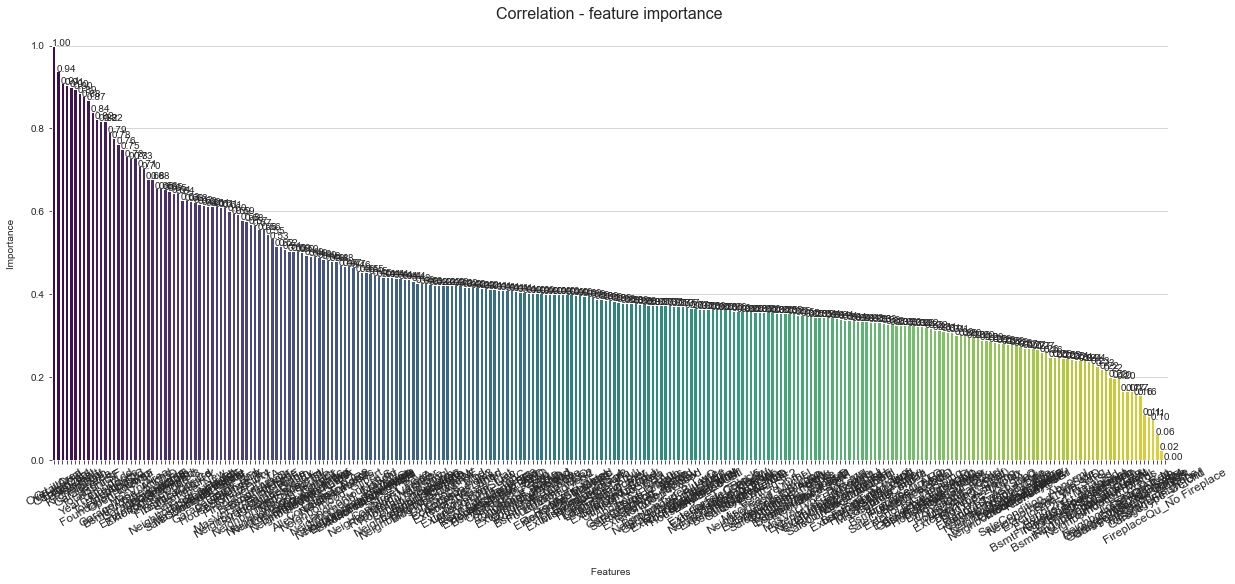

In [72]:
def corr_score(X:pd.DataFrame, y:pd.Series):
    """Calculate target-vars correlation """
    
    # Get entire data
    data = pd.concat([X, y], axis=1)

    # Change data columns after combination
    data.columns = X.columns.to_list() + [y.name]
    
    # Calculate the correlation matrix
    corr_mat = data.corr(method='spearman')

    # get correlated values with target
    target_corr_values = corr_mat[y.name].to_numpy()[:-1]

    
    return target_corr_values, corr_mat[y.name].index[:-1]

corr_rank = FeatureRank(corr_score, X_train, y_train)
corr_rank.feat_imp_plot(title='Correlation - feature importance', sorting=True)

### Multicollinearity Detecting
Variable Inflation Factors (VIF):
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In conclusion, sqft_living15 & sqft_lot15 could be predicted by other variables so we can delete them.

In [73]:
# def check_multi_collinearity(data:pd.DataFrame,):
def check_multi_collinearity(X:pd.DataFrame, y:pd.Series):
    """
    Check if there is multi collinearity between features
    
    Notes:
    --------
    This process needs data to not contain missing values
    """

    vif = pd.DataFrame()
    vif.index = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    # vif["Correlated to target"] = data['SalePrice']
    # vif = vif.sort_values(by='Correlated to target', ascending=False)

    return vif

check_multi_collinearity(X_train, y_train)

,VIF
MSSubClass,33.7175955523
LotArea,2.7134077059
OverallQual,5.4273654075
OverallCond,2.5952583272
YearBuilt,14.1974908600
YearRemodAdd,3.5305964845
MasVnrArea,2.8987580152
ExterQual,3.9878322896
ExterCond,1.5686815893
BsmtQual,7.0626835181


### Feature importance - Entropy

<AxesSubplot:title={'center':'Mutual Info - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

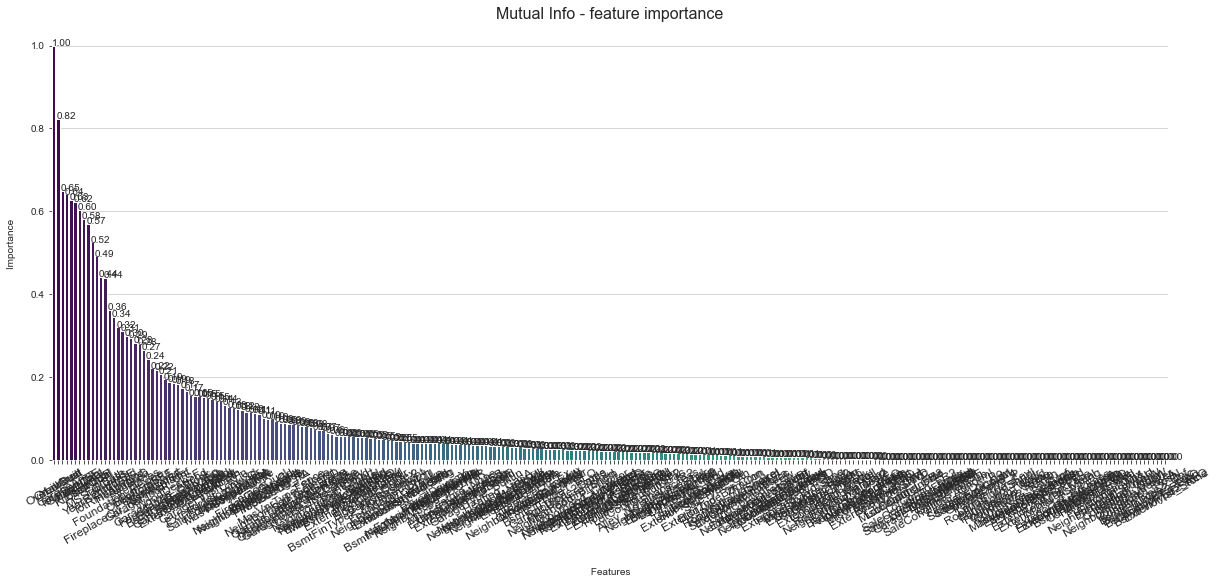

In [74]:
def mutual_info_score(X:pd.DataFrame, y:pd.Series):
    """Calculate Tree-based score"""
    mutual_info = mutual_info_regression(X, y)
    return mutual_info, X.columns

mutual_info_rank = FeatureRank(mutual_info_score, X_train, y_train)
mutual_info_rank.feat_imp_plot('Mutual Info - feature importance', sorting=True)

### Tree-Based

<AxesSubplot:title={'center':'Tree-Based - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

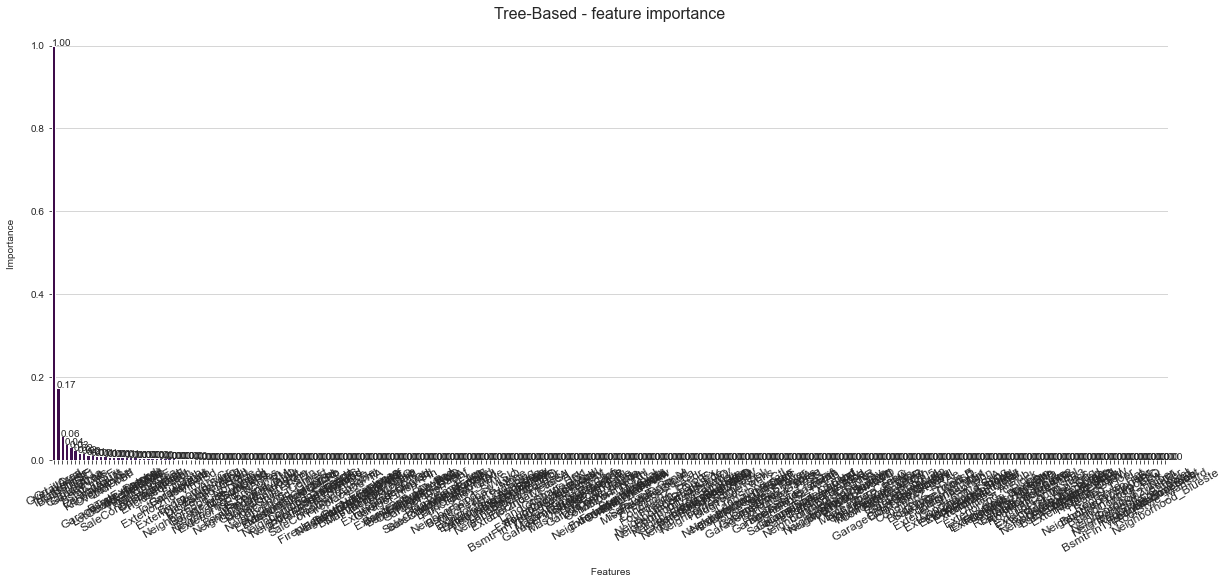

In [77]:
def tree_based_score(X:pd.DataFrame, y:pd.Series):
    """Calculate Tree-based score"""
    dt_model_selector = DecisionTreeRegressor()
    dt_model_selector.fit(X, y)
    return dt_model_selector.feature_importances_, X.columns

tree_based_rank = FeatureRank(tree_based_score, X_train, y_train)
tree_based_rank.feat_imp_plot('Tree-Based - feature importance', sorting=True)

## Transformation
- Since the goal is to use **Linear Regression** which is considered as **Gradient-based** algorithm.Then, numerical variables should be **Normally** distributed.
- **Min-Max** scaler and **Standard** scaler are very sensitive to the *presence* of outliers.


In [35]:
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

### QuantileTransformer

In [36]:
rng = np.random.RandomState(304)

# n_quantiles is set to the training set size rather than the default value
# to avoid a warning being raised by this example
qt_scaler = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)

X_train_norm.iloc[:,:] = qt_scaler.fit_transform(X_train_norm.iloc[:,:])
X_test_norm.iloc[:,:] = qt_scaler.transform(X_test_norm.iloc[:,:])

y_train_norm = pd.Series(qt_scaler.fit_transform(y_train.to_numpy().reshape(-1,1)).ravel(), name='price')
y_test_norm = pd.Series(qt_scaler.transform(y_test.to_numpy().reshape(-1,1)).ravel(), name='price')

In [ ]:
plot_kde(X_train_norm)